###

In [1]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/audio/
   creating: data/audio/pop/
  inflating: data/audio/pop/pop.00027.wav  
  inflating: data/audio/pop/pop.00033.wav  
  inflating: data/audio/pop/pop.00032.wav  
  inflating: data/audio/pop/pop.00026.wav  
  inflating: data/audio/pop/pop.00030.wav  
  inflating: data/audio/pop/pop.00024.wav  
  inflating: data/audio/pop/pop.00018.wav  
  inflating: data/audio/pop/pop.00019.wav  
  inflating: data/audio/pop/pop.00025.wav  
  inflating: data/audio/pop/pop.00031.wav  
  inflating: data/audio/pop/pop.00009.wav  
  inflating: data/audio/pop/pop.00035.wav  
  inflating: data/audio/pop/pop.00021.wav  
  inflating: data/audio/pop/pop.00020.wav  
  inflating: data/audio/pop/pop.00034.wav  
  inflating: data/audio/pop/pop.00008.wav  
  inflating: data/audio/pop/pop.00022.wav  
  inflating: data/audio/pop/pop.00036.wav  
  inflating: data/audio/pop/pop.00037.wav  
  inflating: data/audio/pop/pop.00023.wav  
  inflating: data/audio/pop/

In [2]:
## Importing Libraries

import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from IPython.display import Audio
import seaborn as sns

In [3]:
## Paths & Classes

DATA_DIR = os.path.join('/content', 'data', 'audio')
CLASSES = ['blues','classical','country','disco','hiphop',
           'jazz','metal','pop','reggae','rock']

print(DATA_DIR)

/content/data/audio


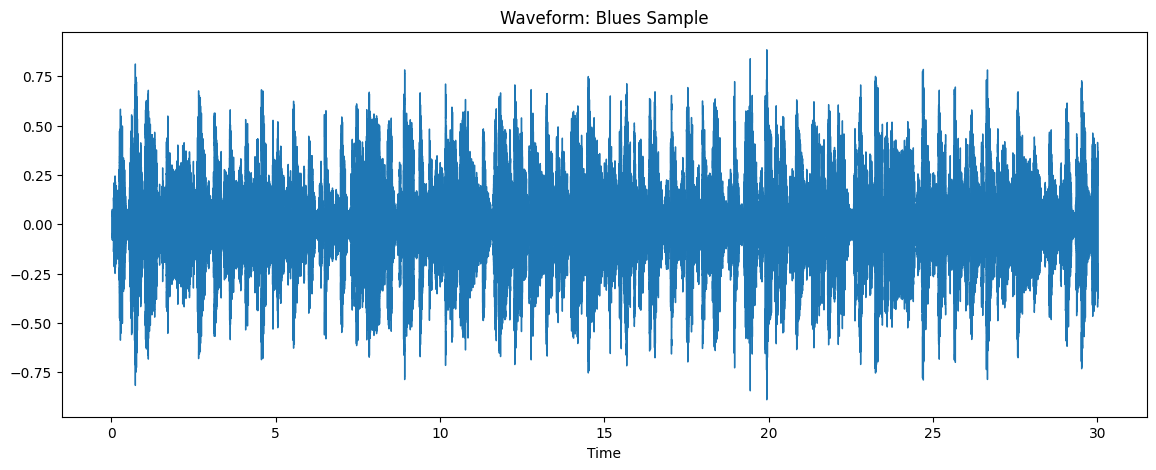

In [4]:
## Visualizing an audio file

random_file = os.path.join(DATA_DIR, 'blues', 'blues.00000.wav')
y, sr = librosa.load(random_file, sr=44100)
plt.figure(figsize=(14,5))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform: Blues Sample")
plt.show()

Audio(data=y, rate=sr)

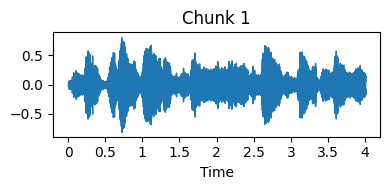

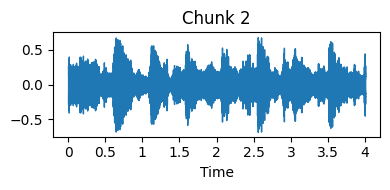

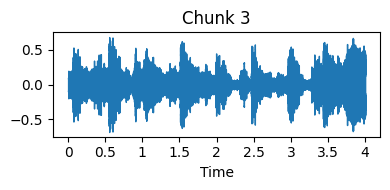

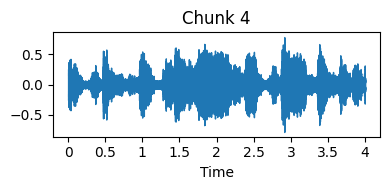

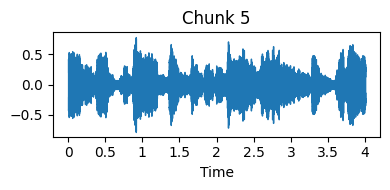

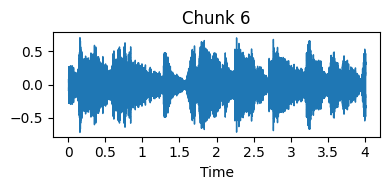

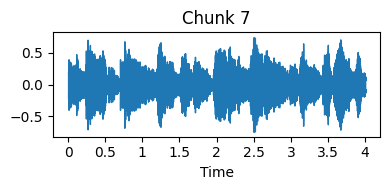

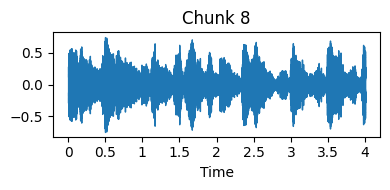

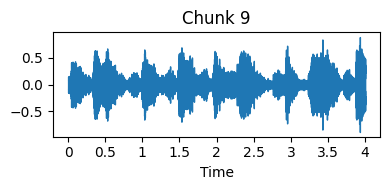

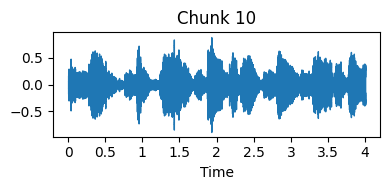

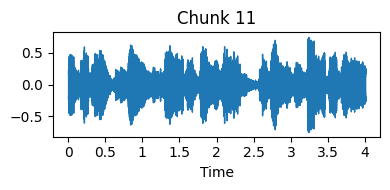

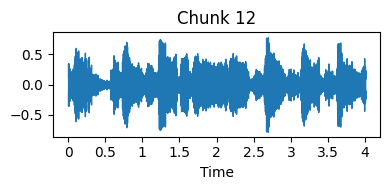

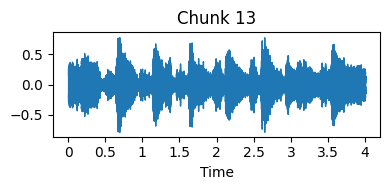

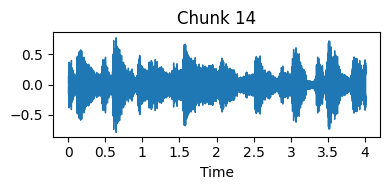

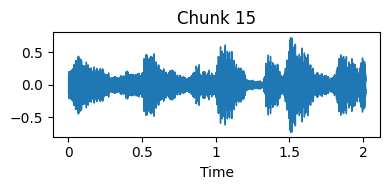

In [5]:
## Chunk-wise Waveform Visualization

chunk_dur, overlap_dur = 4, 2  # in seconds
chunk_samp, overlap_samp = chunk_dur*sr, overlap_dur*sr
num_chunks = int(np.ceil((len(y)-chunk_samp)/(chunk_samp-overlap_samp))) + 1

for i in range(num_chunks):
    start = i*(chunk_samp-overlap_samp)
    end = start + chunk_samp
    chunk = y[start:end]
    plt.figure(figsize=(4,2))
    librosa.display.waveshow(chunk, sr=sr)
    plt.title(f"Chunk {i+1}")
    plt.tight_layout()
    plt.show()

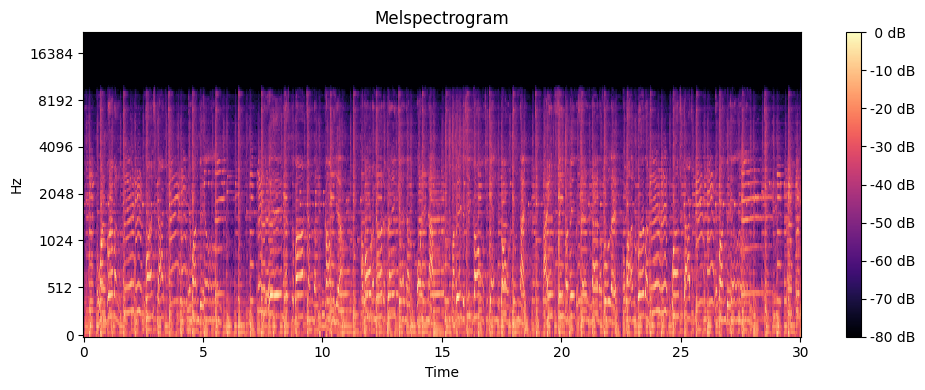

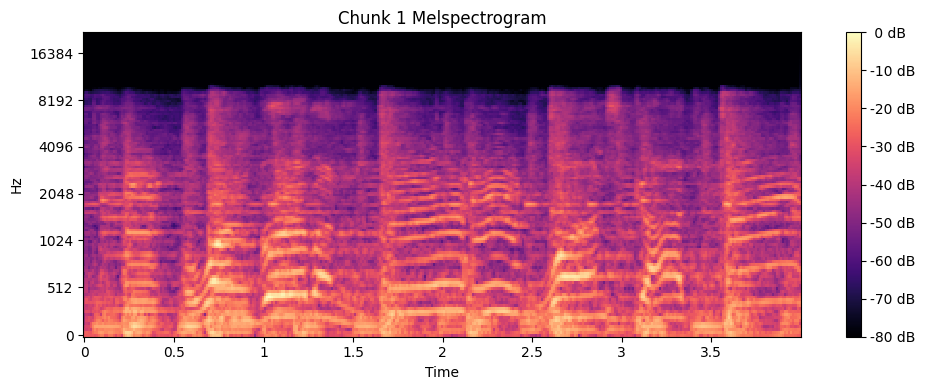

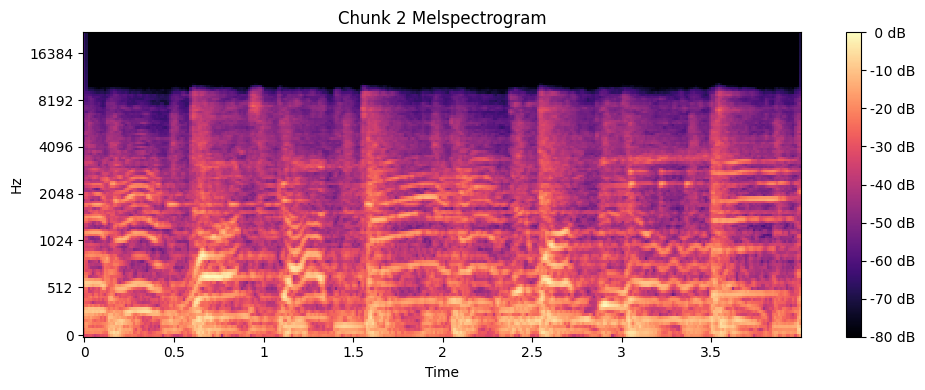

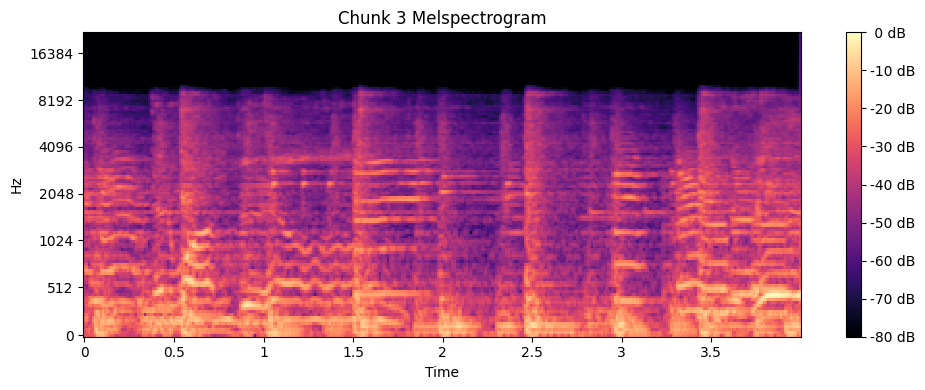

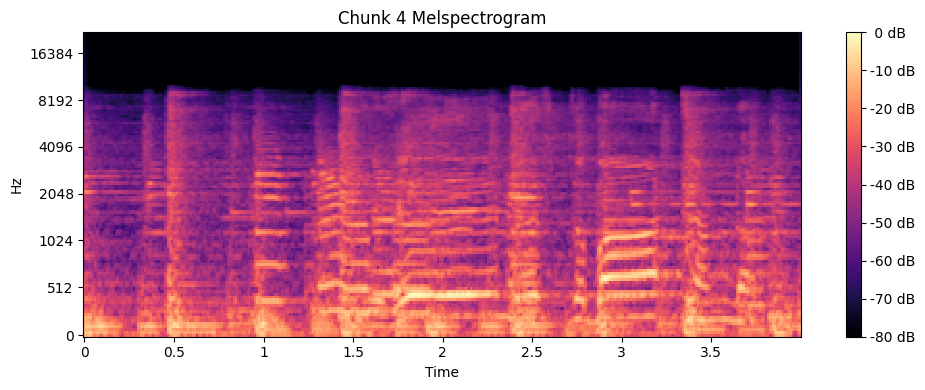

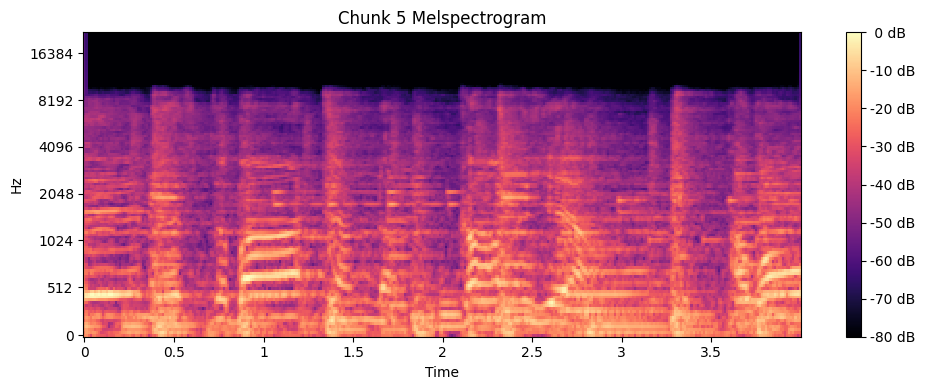

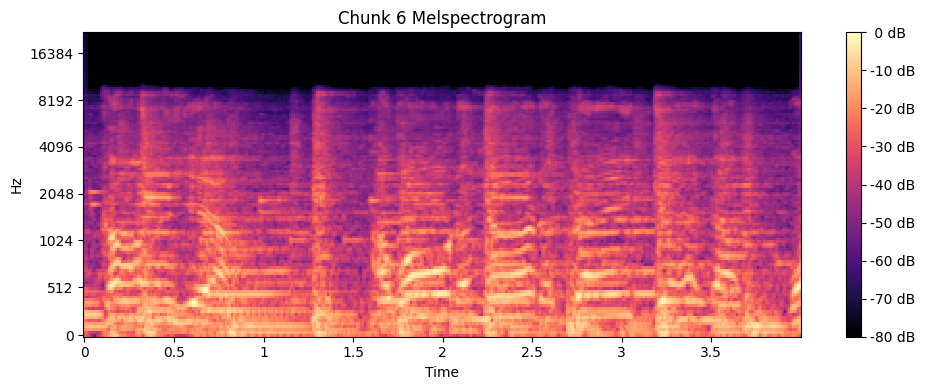

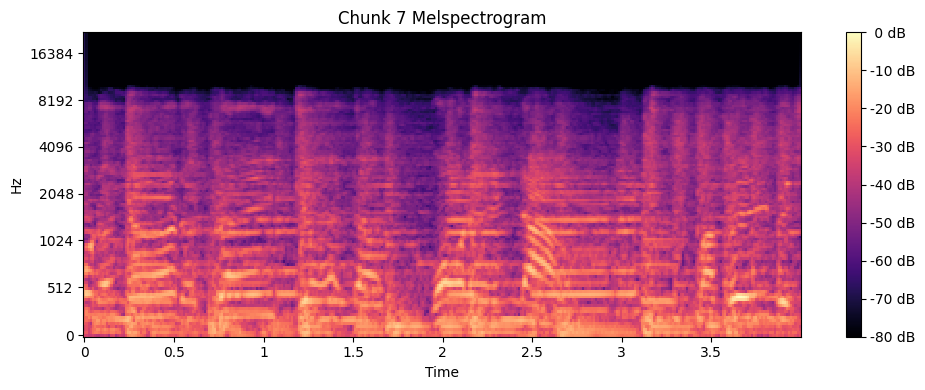

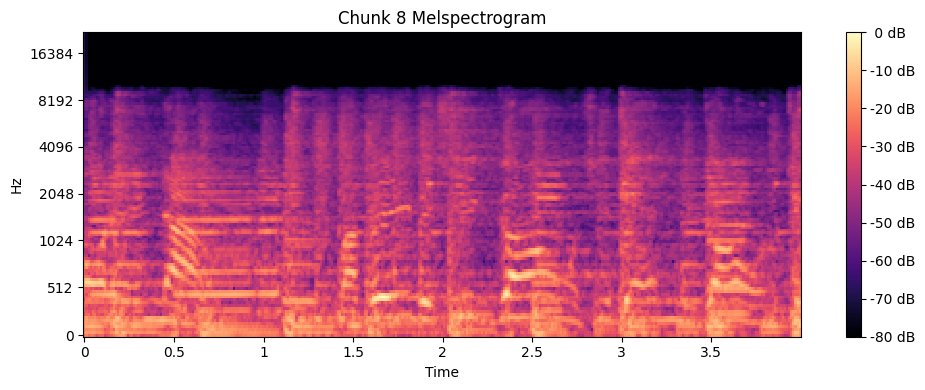

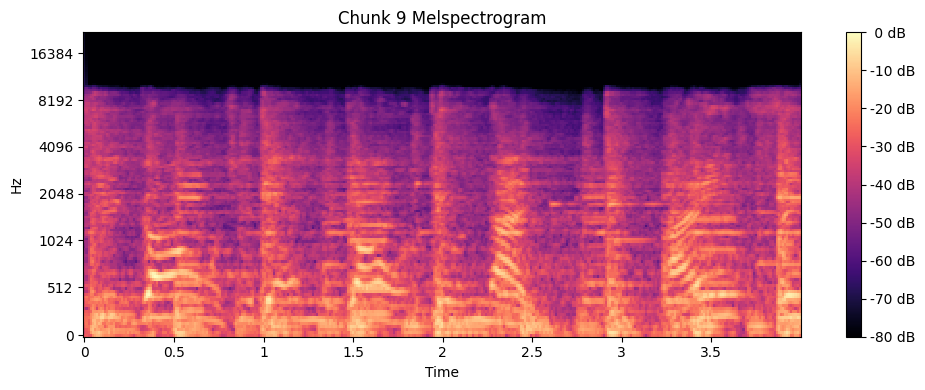

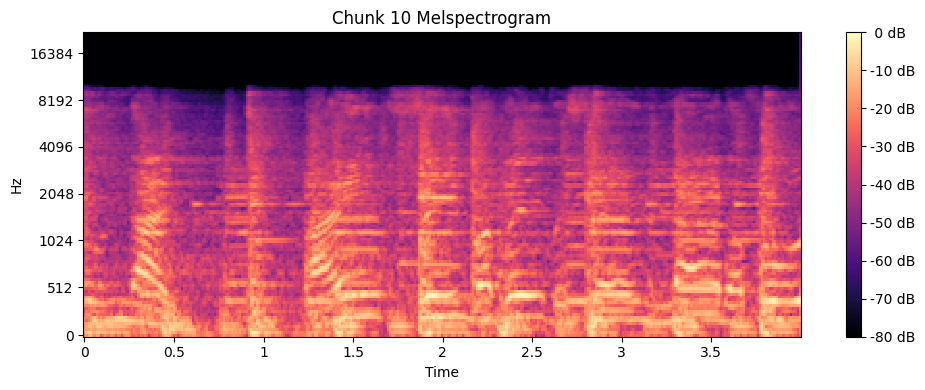

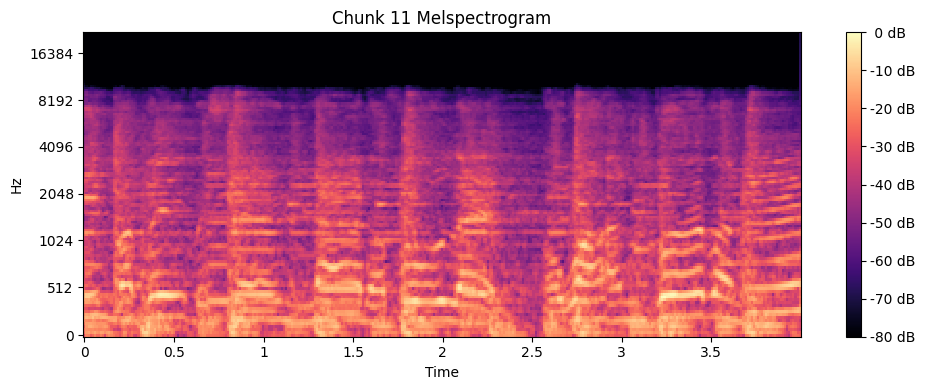

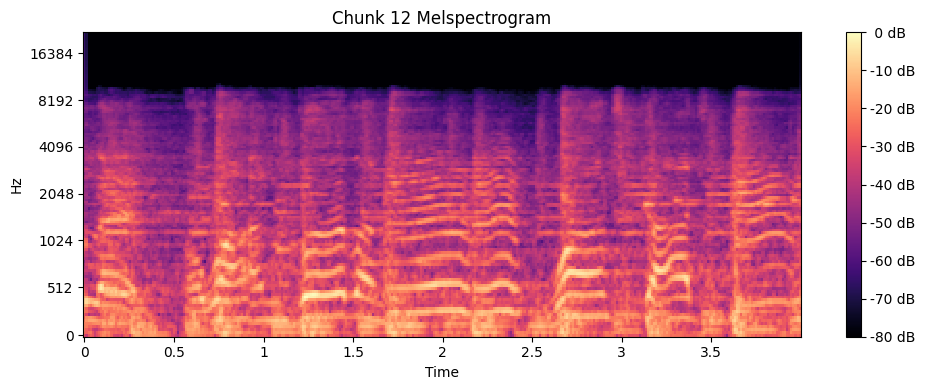

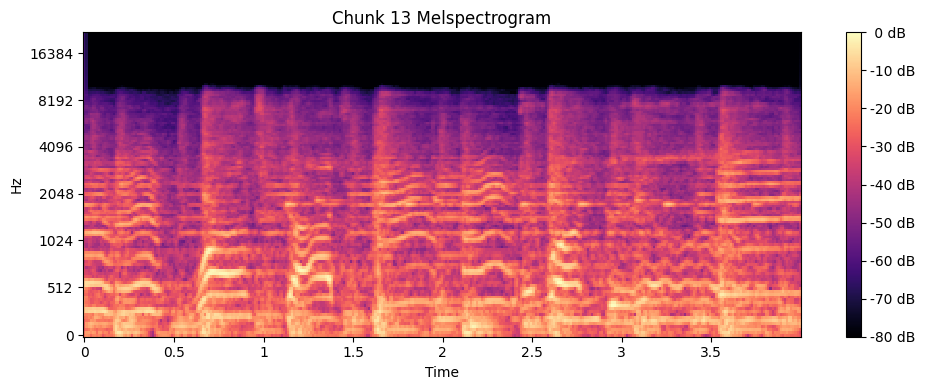

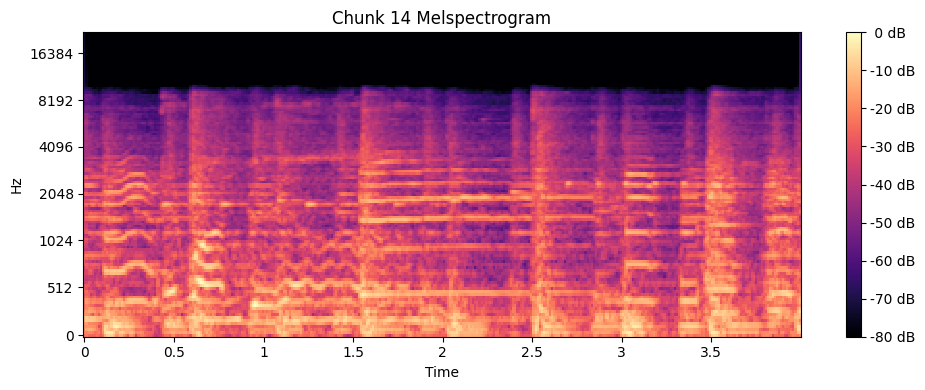

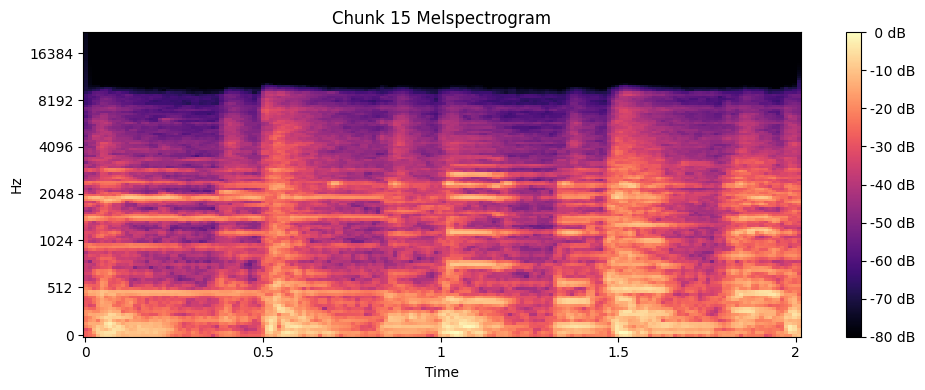

In [6]:
## Melspectrogram Functions

def plot_melspectrogram(y, sr):
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title("Melspectrogram")
    plt.tight_layout()
    plt.show()

plot_melspectrogram(y, sr)


def plot_melspec_chunks(y, sr, chunk_dur=4, overlap_dur=2):
    c_s, o_s = chunk_dur*sr, overlap_dur*sr
    n = int(np.ceil((len(y)-c_s)/(c_s-o_s))) + 1
    for i in range(n):
        start = i*(c_s-o_s); end = start + c_s
        chunk = y[start:end]
        S = librosa.feature.melspectrogram(y=chunk, sr=sr)
        S_db = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(10,4))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title(f"Chunk {i+1} Melspectrogram")
        plt.tight_layout()
        plt.show()

plot_melspec_chunks(y, sr)

In [7]:
## Data Preprocessing

def load_and_preprocess_data(data_dir, classes, target_shape=(150,150)):
    data, labels = [], []

    for idx, genre in enumerate(classes):
        genre_dir = os.path.join(data_dir, genre)
        print("Processing", genre)

        for fname in os.listdir(genre_dir):
            # only WAV files (case-insensitive)
            if not fname.lower().endswith('.wav'):
                continue

            fpath = os.path.join(genre_dir, fname)
            try:
                audio, sr = librosa.load(fpath, sr=None)
            except Exception as e:
                print(f"  ⚠️  Skipping {fpath}: {e}")
                continue

            # chunking parameters
            chunk_dur, overlap_dur = 4, 2
            chunk_samp, overlap_samp = chunk_dur * sr, overlap_dur * sr
            n_chunks = int(np.ceil((len(audio) - chunk_samp) /
                                   (chunk_samp - overlap_samp))) + 1

            for i in range(n_chunks):
                start = i * (chunk_samp - overlap_samp)
                end   = start + chunk_samp
                chunk = audio[start:end]

                # mel → resize
                mel = librosa.feature.melspectrogram(y=chunk, sr=sr)
                mel = resize(np.expand_dims(mel, -1), target_shape)

                data.append(mel)
                labels.append(idx)

    X = np.array(data, dtype=np.float32)
    y = tf.keras.utils.to_categorical(labels, num_classes=len(classes))
    return X, y

# load everything
data, labels = load_and_preprocess_data(DATA_DIR, CLASSES)
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Processing blues
Processing classical
Processing country
Processing disco
Processing hiphop
Processing jazz
Processing metal
Processing pop
Processing reggae
Processing rock
Data shape: (14990, 150, 150, 1)
Labels shape: (14990, 10)


In [8]:
## Train/Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

In [9]:
## Model Building

model = tf.keras.models.Sequential([
    Conv2D(32,3,padding='same',activation='relu', input_shape=X_train[0].shape),
    Conv2D(32,3,activation='relu'),
    MaxPool2D(2,2),

    Conv2D(64,3,padding='same',activation='relu'),
    Conv2D(64,3,activation='relu'),
    MaxPool2D(2,2),

    Conv2D(128,3,padding='same',activation='relu'),
    Conv2D(128,3,activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.3),

    Conv2D(256,3,padding='same',activation='relu'),
    Conv2D(256,3,activation='relu'),
    MaxPool2D(2,2),

    Conv2D(512,3,padding='same',activation='relu'),
    Conv2D(512,3,activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(1200, activation='relu'),
    Dropout(0.45),
    Dense(len(CLASSES), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
## Training

history = model.fit(
    X_train, Y_train,
    epochs=30, batch_size=32,
    validation_data=(X_test, Y_test)
)

model.save(os.path.join('/content','models','trained_model.h5'))

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 131ms/step - accuracy: 0.2014 - loss: 2.1409 - val_accuracy: 0.4076 - val_loss: 1.6556
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4462 - loss: 1.5639 - val_accuracy: 0.5740 - val_loss: 1.2347
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.5655 - loss: 1.2330 - val_accuracy: 0.6518 - val_loss: 1.0112
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.6534 - loss: 1.0019 - val_accuracy: 0.7088 - val_loss: 0.8457
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.7097 - loss: 0.8387 - val_accuracy: 0.7502 - val_loss: 0.7550
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.7545 - loss: 0.7108 - val_accuracy: 0.7755 - val_loss: 0.6613
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.7933 - loss: 0.5889 - val_accuracy: 0.7915 - val_loss: 0.6083
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.8359 - loss: 0.4918 -

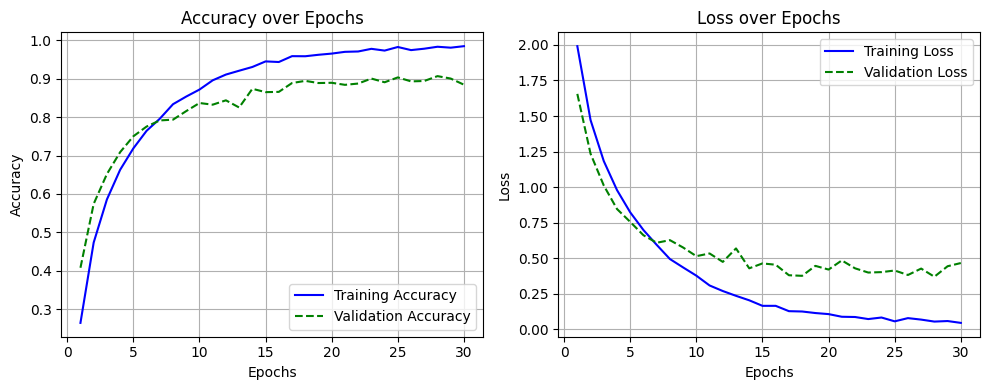

In [12]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'g--', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()